# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as typ
from pyspark.sql.functions import udf, countDistinct, split, count, \
when, sum as ssum, col, last, lit, concat, avg, desc
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
%matplotlib inline

In [2]:
# Create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load the dataset
sparkify_event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_event_data)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# Find dataset size
df.count(), len(df.columns)

(286500, 18)

In [5]:
# Count null values by columns
df_nulls = df.select([typ.count(typ.when(typ.isnull(c), c)).alias(c) for c in df.columns])
df_nulls.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



There is a clear split of missing data, some events where the artist, song and length is missing. Firstly i will analyse this data to see if it is valid.

In [6]:
# Visualise data
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [7]:
# View data as pandas dataframe to get familiar view of dataset.
df_pandas = df.toPandas()
df_pandas.head(n=10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [8]:
# Display data header where the artist column is null/none
artist_nulls = df_pandas[df_pandas['artist'].isnull()]
artist_nulls.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
11,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
14,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
35,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
44,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54


Here, these values are null because the event or 'page' column indicates a different event to "NextSong" such as "Roll Advert" or "Downgrade"

Secondly there are 8346 records missing where the firstName, lastName, gender, location, registration and userAgent is missing. Here i will review this data to see if it needs cleaning.

In [9]:
# Display data header where the firstName column is null/none
other_nulls = df_pandas[df_pandas['firstName'].isnull()]
other_nulls.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
57,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
58,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
59,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
60,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
76,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,


In [10]:
# Identify column content from auth
other_nulls.groupby('auth')['auth'].count()

auth
Guest           97
Logged Out    8249
Name: auth, dtype: int64

Dataset in the initial view appears to be clean and shows separation where null values are for specific events. We should bare this in mind when defining the churn criteria. This does not have any indicator to which user so these events would not be required in the dataset.

Final check is to review if there are any duplicate entries.

In [11]:
# Check number of duplicates
df_pandas.duplicated().sum()

0

In summary, the only data that needs cleaning is to remove rows where the userId is blank.

In [12]:
# Function for cleaning data
def clean_data(df):
    '''
    Cleans dataset to remove null values where the userId is blank and drop any duplicates.
    '''
    df = df.filter(df["userId"] != "")
    df = df.dropDuplicates()
    return df

In [13]:
# Run function
clean_data = clean_data(df)

In [14]:
# Identify new data siza - Expected = original 286500 - 8346 missing records (278154)
clean_data.count(), len(clean_data.columns)

(278154, 18)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

------------------------
### Initial Data Exploration Approach

Initially i will carry out a rough exploration of the data to get a feel for how the data is presented and whether any features need to be engineered to help define the churn. I will do this by addressing the following:

- 1) Understand the data accross a time range, so firstly find the timespan of the dataset.
- 2) Identify how many users are in the dataset.
- 3) Any key correlations between users (in terms of gender), location and type of account (paid or free).
- 4) Typical usage (times of day etc...).

In [15]:
# Convert time stamp to a readable format for both ts and registration

# Full date & time string
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
# Hour of day
convert_ts_hr = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H"))
# Apply iterations
df_cleaned = clean_data.withColumn("datetime", convert_ts('ts'))
df_cleaned = df_cleaned.withColumn("hourofday", convert_ts_hr('ts'))
df_cleaned = df_cleaned.withColumn("registration_date", convert_ts('registration'))

In [16]:
# Visualise new date time formats
df_cleaned.take(2)

[Row(artist='The Futureheads', auth='Logged In', firstName='Ainsley', gender='F', itemInSession=80, lastName='Farley', length=120.81587, level='free', location='McAllen-Edinburg-Mission, TX', method='PUT', page='NextSong', registration=1538304455000, sessionId=187, song='Robot', status=200, ts=1538373133000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='78', datetime='2018-10-01 05:52:13', hourofday='2018-10-01 05', registration_date='2018-09-30 10:47:35'),
 Row(artist=None, auth='Logged In', firstName='Ainsley', gender='F', itemInSession=81, lastName='Farley', length=None, level='free', location='McAllen-Edinburg-Mission, TX', method='PUT', page='Thumbs Down', registration=1538304455000, sessionId=187, song=None, status=307, ts=1538373134000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='78', datetime='2018-10-01 05

In [17]:
# Find min and max date time from of the events to get timespan
df_cleaned.agg(typ.min('datetime'), typ.max('datetime')).show()

+-------------------+-------------------+
|      min(datetime)|      max(datetime)|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-12-03 01:11:16|
+-------------------+-------------------+



In [18]:
# Find from original pandas dataframe the user ID scope
df_pandas.groupby('userId')['userId'].nunique()

userId
          1
10        1
100       1
100001    1
100002    1
100003    1
100004    1
100005    1
100006    1
100007    1
100008    1
100009    1
100010    1
100011    1
100012    1
100013    1
100014    1
100015    1
100016    1
100017    1
100018    1
100019    1
100021    1
100022    1
100023    1
100024    1
100025    1
101       1
102       1
103       1
         ..
72        1
73        1
74        1
75        1
76        1
77        1
78        1
79        1
8         1
80        1
81        1
82        1
83        1
84        1
85        1
86        1
87        1
88        1
89        1
9         1
90        1
91        1
92        1
93        1
94        1
95        1
96        1
97        1
98        1
99        1
Name: userId, Length: 226, dtype: int64

The list of user IDs does not run in a clean sequential range (for example 1-100).

In [19]:
# Check an example of one of the higher range user IDs to ensure it it valid.
df_pandas.loc[df_pandas['userId'] == "100005"].head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
213836,None,Logged In,Cason,M,0,Smith,NaN,free,"Monroe, LA",GET,Home,1.532611e+12,5,None,200,1538407015000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",100005
213837,Michael Jackson,Logged In,Cason,M,1,Smith,314.53995,free,"Monroe, LA",PUT,NextSong,1.532611e+12,5,Thriller,200,1538407016000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",100005
213838,None,Logged In,Cason,M,2,Smith,NaN,free,"Monroe, LA",PUT,Thumbs Up,1.532611e+12,5,None,307,1538407017000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",100005
213839,Frightened Rabbit,Logged In,Cason,M,3,Smith,253.93587,free,"Monroe, LA",PUT,NextSong,1.532611e+12,5,Floating In The Forth,200,1538407330000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",100005
213840,Afroman,Logged In,Cason,M,4,Smith,177.13587,free,"Monroe, LA",PUT,NextSong,1.532611e+12,5,The American Dream,200,1538407583000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",100005


Looks fine! So i will user a distinct count on the cleaned dataframe to count the number of user IDs after the blanks have been removed.

In [20]:
# Count unique users in the dataset.
df_cleaned.agg(countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



In [21]:
# Find gender split
df_cleaned.groupBy("gender").agg(typ.countDistinct("userId")).show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                   104|
|     M|                   121|
+------+----------------------+



Data shows a relatively even split in gender between the dataset with a slight potential skew on number of registered male users.

In [22]:
# Find event split by gender
df_cleaned.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



Despite having less registered users, the female users shows more activity / usage in the events list. This could contribute to tuning the model to particular criteria around the types of users.

In [23]:
# Count number of locations
df_cleaned.agg(countDistinct("location")).show()

+------------------------+
|count(DISTINCT location)|
+------------------------+
|                     114|
+------------------------+



In [24]:
# Split the location column out by delimiter to see if there can be any location groups / states
df_cleaned = df_cleaned.withColumn('area', split(df['location'], ',')[1])

In [25]:
# See event logs by area
df_cleaned.groupBy('area').count().sort("count", ascending=False).show(114)

+------------+-----+
|        area|count|
+------------+-----+
|          CA|46771|
|    NY-NJ-PA|23684|
|          TX|23494|
|       MA-NH|13873|
|          FL|13190|
|          NC|10688|
|       NC-SC| 7780|
|          CO| 7493|
|          MI| 7216|
|          NJ| 7001|
|       KY-IN| 6880|
|          CT| 6720|
| PA-NJ-DE-MD| 5890|
|    IL-IN-WI| 5114|
|       MO-IL| 4858|
|          AZ| 4846|
|          NH| 4764|
|          VA| 4651|
|          MS| 4634|
|          NY| 4536|
|          GA| 4236|
|          WA| 3772|
|          AK| 3563|
|          KY| 3462|
|          OH| 3432|
| DC-VA-MD-WV| 3090|
|          PA| 2923|
|          AL| 2857|
|       GA-AL| 2716|
|          MD| 2710|
|       MO-KS| 2562|
|          MT| 2386|
|          WV| 2278|
|       MN-WI| 2241|
|          IL| 2102|
|          NV| 2042|
|       TN-VA| 1863|
|          OK| 1842|
|          TN| 1672|
|          WI| 1342|
|          IN| 1262|
|          LA| 1171|
|          UT| 1102|
|       IL-MO| 1003|
|       MD-WV

In [26]:
# Find number of state groups
df_cleaned.agg(countDistinct("area")).show()

+--------------------+
|count(DISTINCT area)|
+--------------------+
|                  58|
+--------------------+



In [27]:
# Group data and count distinct users by area
df_cleaned.groupBy("area").agg(typ.countDistinct("userId")).sort("count(DISTINCT userId)", ascending=False).show(58)

+------------+----------------------+
|        area|count(DISTINCT userId)|
+------------+----------------------+
|          CA|                    33|
|          TX|                    16|
|    NY-NJ-PA|                    15|
|          FL|                    14|
|          CT|                     7|
|          AZ|                     7|
|          NC|                     6|
|    IL-IN-WI|                     6|
|       MO-IL|                     6|
|       NC-SC|                     6|
| PA-NJ-DE-MD|                     5|
|          NY|                     5|
|          MI|                     5|
|       MA-NH|                     5|
|          WA|                     4|
| DC-VA-MD-WV|                     4|
|          AL|                     4|
|          GA|                     4|
|          CO|                     4|
|          MS|                     3|
|          KY|                     3|
|          NV|                     3|
|          PA|                     3|
|          O

This shows that nearly 35% of the users fall into the top 4 areas / location groups and the remainder of the dataset is fairly sparse. This information could be userful in the feature engineering stage.

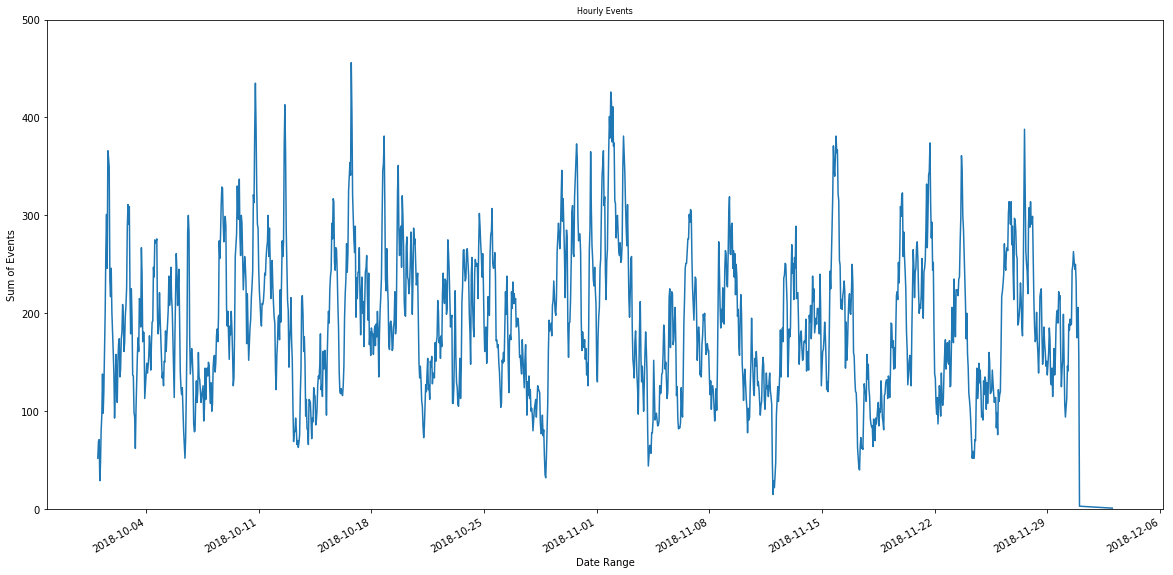

In [28]:
# Create panda daterange for plot
pandas_daterange = df_cleaned.groupBy('hourofday').count().sort('hourofday', ascending=True).toPandas()
pandas_daterange['hourofday'] = pd.to_datetime(pandas_daterange['hourofday'])
pandas_daterange.set_index('hourofday', inplace=True)

# Find the sum of events per hour
events = pandas_daterange.sum()[0]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
pandas_daterange.plot(ax=ax, legend=False)
ax.axhline(events)
ax.set_title("Hourly Events", fontsize=8)
ax.set_xlabel("Date Range")
ax.set_ylabel("Sum of Events")
plt.ylim(0, 500)
plt.show()

In [29]:
# Identify the auth categories
df_cleaned.groupBy("auth").agg(countDistinct("userId")).show()

+---------+----------------------+
|     auth|count(DISTINCT userId)|
+---------+----------------------+
|Cancelled|                    52|
|Logged In|                   225|
+---------+----------------------+



In [30]:
# Identify the event categories
df_cleaned.groupBy("page").agg(count("userId")).sort("count(userId)", ascending=False).show()

+--------------------+-------------+
|                page|count(userId)|
+--------------------+-------------+
|            NextSong|       228108|
|           Thumbs Up|        12551|
|                Home|        10082|
|     Add to Playlist|         6526|
|          Add Friend|         4277|
|         Roll Advert|         3933|
|              Logout|         3226|
|         Thumbs Down|         2546|
|           Downgrade|         2055|
|            Settings|         1514|
|                Help|         1454|
|             Upgrade|          499|
|               About|          495|
|       Save Settings|          310|
|               Error|          252|
|      Submit Upgrade|          159|
|    Submit Downgrade|           63|
|              Cancel|           52|
|Cancellation Conf...|           52|
+--------------------+-------------+



---
### Defining Churn
Here i will define the criteria for a churn and create a new column for labelling this event.

In [31]:
# Define iteration action
churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0)

In [32]:
# Iterate through data, create new column and log a '1' where Cancellation Confirmation is seen
churn_data = df_cleaned.withColumn("churn", churn("page"))

In [33]:
# Visualise the data in pandas dataframe
pd_churn = churn_data.toPandas()
pd_churn.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,datetime,hourofday,registration_date,area,churn
0,The Futureheads,Logged In,Ainsley,F,80,Farley,120.81587,free,"McAllen-Edinburg-Mission, TX",PUT,...,Robot,200,1538373133000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",78,2018-10-01 05:52:13,2018-10-01 05,2018-09-30 10:47:35,TX,0
1,None,Logged In,Ainsley,F,81,Farley,NaN,free,"McAllen-Edinburg-Mission, TX",PUT,...,None,307,1538373134000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",78,2018-10-01 05:52:14,2018-10-01 05,2018-09-30 10:47:35,TX,0
2,O'Rosko Raricim,Logged In,Madison,F,74,Morales,90.56608,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,...,Terre Promise,200,1538384924000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",25,2018-10-01 09:08:44,2018-10-01 09,2018-09-07 02:24:59,FL,0
3,Morgan Page,Logged In,Panav,M,23,Myers,235.54567,paid,"Morgantown, WV",PUT,...,Strange Condition,200,1538394878000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",15,2018-10-01 11:54:38,2018-10-01 11,2018-09-29 16:37:25,WV,0
4,None,Logged In,Ethan,M,15,Raymond,NaN,free,"Hartford-West Hartford-East Hartford, CT",GET,...,None,200,1538402423000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",27,2018-10-01 14:00:23,2018-10-01 14,2018-08-14 11:26:36,CT,0


In [34]:
# See header of data where churn is equal to 1
pd_churn.loc[pd_churn['churn'] == "1"].head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,datetime,hourofday,registration_date,area,churn
1067,None,Cancelled,Mahi,F,17,Robinson,NaN,free,"Houston-The Woodlands-Sugar Land, TX",GET,...,None,200,1542038645000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,100022,2018-11-12 16:04:05,2018-11-12 16,2018-09-25 17:58:55,TX,1
1185,None,Cancelled,Keegan,M,46,Rivera,NaN,free,"Orlando-Kissimmee-Sanford, FL",GET,...,None,200,1542472842000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,200020,2018-11-17 16:40:42,2018-11-17 16,2018-09-02 16:51:56,FL,1
1994,None,Cancelled,Teagan,F,306,Roberts,NaN,paid,"New Philadelphia-Dover, OH",GET,...,None,200,1541463632000,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,28,2018-11-06 00:20:32,2018-11-06 00,2018-09-22 16:47:45,OH,1
2440,None,Cancelled,Troy,M,61,Mathis,NaN,free,"San Francisco-Oakland-Hayward, CA",GET,...,None,200,1540611104000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100009,2018-10-27 03:31:44,2018-10-27 03,2018-09-19 17:00:37,CA,1
6620,None,Cancelled,Tina,F,115,Thompson,NaN,paid,"North Wilkesboro, NC",GET,...,None,200,1543073753000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",100015,2018-11-24 15:35:53,2018-11-24 15,2018-09-17 18:29:49,NC,1


Furthermore, a churn tag is required to identify each event that a churn user carried out.

In [35]:
# Define churn tag for each churn user activity.
window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
churn_data = churn_data.withColumn("churn", ssum("churn").over(window))

In [36]:
# Visualise data after churn tag to ensure a churn value of 1 is seen whether the event it cancellation or not
churn_data.filter("churn = 1").take(5)

[Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', itemInSession=10, lastName='Hart', length=None, level='free', location='Corpus Christi, TX', method='GET', page='Cancellation Confirmation', registration=1533157139000, sessionId=174, song=None, status=200, ts=1539318918000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', datetime='2018-10-12 04:35:18', hourofday='2018-10-12 04', registration_date='2018-08-01 20:58:59', area=' TX', churn=1.0),
 Row(artist=None, auth='Logged In', firstName='Mason', gender='M', itemInSession=9, lastName='Hart', length=None, level='free', location='Corpus Christi, TX', method='PUT', page='Cancel', registration=1533157139000, sessionId=174, song=None, status=307, ts=1539318918000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', datetime='20

--- 
### Churn Data Exploration

Now i will explore the dataset by churn criteria to further support the feature engineering. The features i will explore will be:

- 1) gender.
- 2) level (Type of Subscription).
- 3) location - Both by area and location.
- 4) page - Typical Usage (number of events....e.g playlists, adverts, liking/disliking content.
- 5) artists / song - Number of unique songs and artists listened to.
- 6) length - Duration of activity.
- 7) user Agent - Type of system.
- 8) ts - Multiple exploration techniques could be applied to this to combine activities accross time range.

Features which do not show any stand out initial value without exploring the rest of the data set are:

- auth
- firstName
- lastName
- itemInSession
- method
- registration
- sessionId
- status
- userId (As its own analysis. It will be used to help idenitfy unique users)

The results of the modelling stage will determine whether i need to use / explore more features or adjust the model parameters.

In [37]:
# Count total number of churned users
churn_data.groupBy("churn").agg(typ.countDistinct("userId")).show()

+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
|  0.0|                   173|
|  1.0|                    52|
+-----+----------------------+



In [38]:
# Identify the amount of users who churn by gender.
churn_data.groupBy("churn", "gender").agg(typ.countDistinct("userId")).show()

+-----+------+----------------------+
|churn|gender|count(DISTINCT userId)|
+-----+------+----------------------+
|  0.0|     F|                    84|
|  1.0|     F|                    20|
|  1.0|     M|                    32|
|  0.0|     M|                    89|
+-----+------+----------------------+



In [39]:
# Identify the amount of users who churn by type of membership.
churn_data.select(col("userId"), last("level").over(Window.partitionBy(["userId"])).alias("level"),\
    col("churn")).dropDuplicates() \
    .groupBy("churn", "level").count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|  1.0| free|   44|
|  1.0| paid|    8|
|  0.0| free|  133|
|  0.0| paid|   40|
+-----+-----+-----+



In [40]:
# Identify the amount of users who churn by area
churn_data.filter(churn_data["churn"] == 1).groupBy("churn", "area")\
    .agg(typ.countDistinct("userId")).sort("count(DISTINCT userId)", ascending=False).show(52)

+-----+------------+----------------------+
|churn|        area|count(DISTINCT userId)|
+-----+------------+----------------------+
|  1.0|          CA|                     6|
|  1.0|    NY-NJ-PA|                     5|
|  1.0|          MI|                     3|
|  1.0|          TX|                     3|
|  1.0|          FL|                     3|
|  1.0|          CO|                     2|
|  1.0|          AL|                     2|
|  1.0|          MS|                     2|
|  1.0| PA-NJ-DE-MD|                     2|
|  1.0|          KY|                     2|
|  1.0|          AZ|                     2|
|  1.0|          OH|                     2|
|  1.0|          WA|                     2|
|  1.0|          LA|                     1|
|  1.0|          OR|                     1|
|  1.0|    IL-IN-WI|                     1|
|  1.0|          NC|                     1|
|  1.0|          MT|                     1|
|  1.0| DC-VA-MD-WV|                     1|
|  1.0|       IL-MO|            

In [41]:
# Identify the amount of users who churn by location
churn_data.filter(churn_data["churn"] == 1).groupBy("churn", "location")\
    .agg(typ.countDistinct("userId")).sort("count(DISTINCT userId)", ascending=False).show(52)

+-----+--------------------+----------------------+
|churn|            location|count(DISTINCT userId)|
+-----+--------------------+----------------------+
|  1.0|New York-Newark-J...|                     5|
|  1.0|Los Angeles-Long ...|                     3|
|  1.0|           Flint, MI|                     2|
|  1.0|Miami-Fort Lauder...|                     2|
|  1.0|Philadelphia-Camd...|                     2|
|  1.0|Spokane-Spokane V...|                     2|
|  1.0|Phoenix-Mesa-Scot...|                     2|
|  1.0|         Jackson, MS|                     2|
|  1.0|          London, KY|                     1|
|  1.0|Albany-Schenectad...|                     1|
|  1.0|Houston-The Woodl...|                     1|
|  1.0|Virginia Beach-No...|                     1|
|  1.0|Oxnard-Thousand O...|                     1|
|  1.0|Colorado Springs, CO|                     1|
|  1.0|Cleveland-Elyria, OH|                     1|
|  1.0|Greenville-Anders...|                     1|
|  1.0|India

In [42]:
# Show count of events and categorise if the user churns during the membership
churn_data.groupBy(["churn","page"]).count().withColumn("percentage", col("count")/ssum("count")\
          .over(Window.partitionBy("churn"))) \
          .sort("churn","percentage", ascending=False).show(40)

+-----+--------------------+------+--------------------+
|churn|                page| count|          percentage|
+-----+--------------------+------+--------------------+
|  1.0|            NextSong| 36394|  0.8112072039942939|
|  1.0|           Thumbs Up|  1859| 0.04143634094151213|
|  1.0|                Home|  1672|0.037268188302425106|
|  1.0|     Add to Playlist|  1038|0.023136590584878745|
|  1.0|         Roll Advert|   967|0.021554029957203995|
|  1.0|          Add Friend|   636|0.014176176890156919|
|  1.0|              Logout|   553| 0.01232614122681883|
|  1.0|         Thumbs Down|   496|0.011055634807417974|
|  1.0|           Downgrade|   337|0.007511590584878745|
|  1.0|            Settings|   270|0.006018188302425107|
|  1.0|                Help|   239|0.005327211126961484|
|  1.0|             Upgrade|   112|0.002496433666191...|
|  1.0|       Save Settings|    58|0.001292796005706134|
|  1.0|               About|    56|0.001248216833095...|
|  1.0|              Cancel|   

In [43]:
# Retrieve counts of page actions 
event_churn_summary = churn_data.groupBy(["churn","page"]).count() \
          .withColumn("percentage", col("count")/ssum("count")\
          .over(Window.partitionBy("churn"))) \
          .sort("churn","percentage", ascending=False)

# Filter out Next Song because it will skew the dataset as a heavy percentage.
event_churn_summary = event_churn_summary.filter(event_churn_summary["page"] != "NextSong")

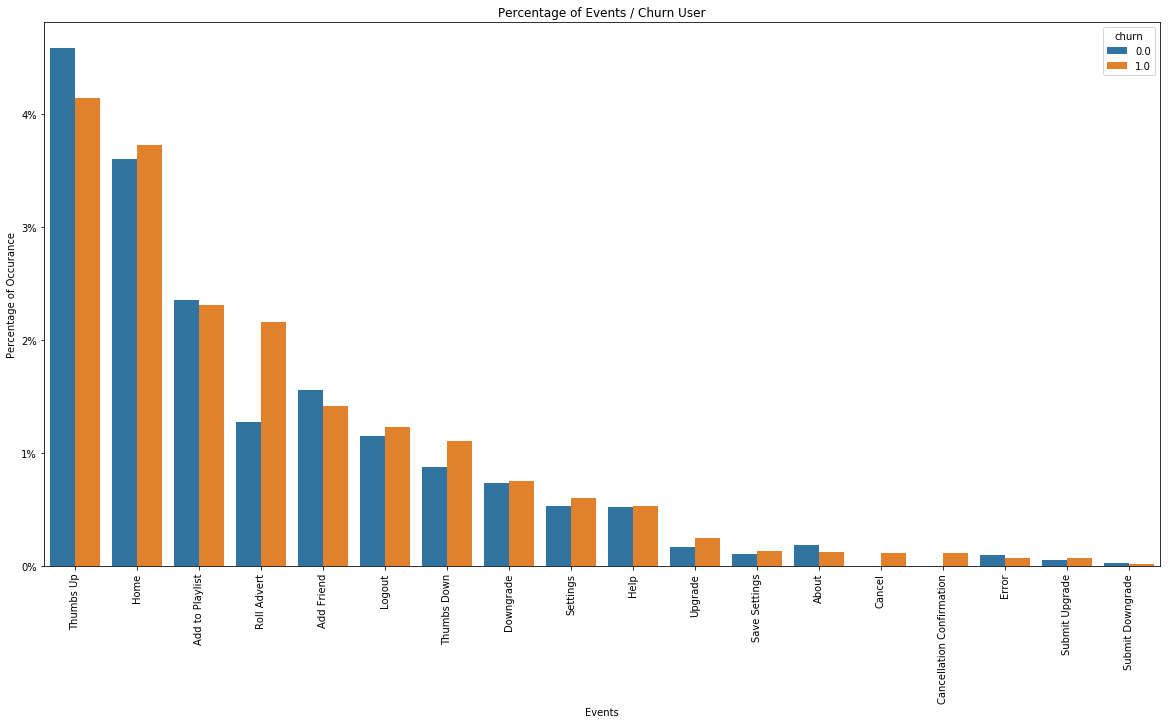

In [44]:
# Convert dataframe to pandas
pandas_churn_data = event_churn_summary.toPandas()

# Plot Size
fig=plt.figure(figsize=(20,10))

#Initiate Plot
sns.barplot(x="page", y="percentage", hue="churn", data=pandas_churn_data);

# X-axis descriptions at 90degrees
plt.xticks(rotation=90);

# Axis Labelling
plt.title("Percentage of Events / Churn User")
plt.xlabel("Events")
plt.ylabel("Percentage of Occurance")

# Turning the y-axis into a percentage rather than decimal
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

This plot shows some interesting correlations. It suggests that a user who uses the "thumbs up" function is less likely to churn and users who use the "thumbs down" function are more likely to churn. Furthermore the biggest difference is between the two sets of users is seen with the "Roll Advert" function.

In [45]:
# Count activity by churn user and non churn user
activity_count = churn_data.groupBy('churn','userId').agg((typ.countDistinct(typ.col('datetime')))\
                 .alias("activity")).orderBy('activity')
activity_count.show()

+-----+------+--------+
|churn|userId|activity|
+-----+------+--------+
|  0.0|   135|       6|
|  0.0|   156|       6|
|  1.0|   125|      10|
|  1.0|100011|      22|
|  0.0|300003|      34|
|  1.0|100024|      36|
|  0.0|    22|      40|
|  1.0|100006|      44|
|  0.0|   133|      44|
|  0.0|    90|      45|
|  0.0|    68|      48|
|  0.0|   134|      52|
|  1.0|   122|      61|
|  0.0|    64|      66|
|  0.0|    34|      72|
|  1.0|100017|      75|
|  0.0|200007|      76|
|  1.0|100003|      77|
|  0.0|   116|      79|
|  0.0|200012|      83|
+-----+------+--------+
only showing top 20 rows



Text(0,0.5,'Count')

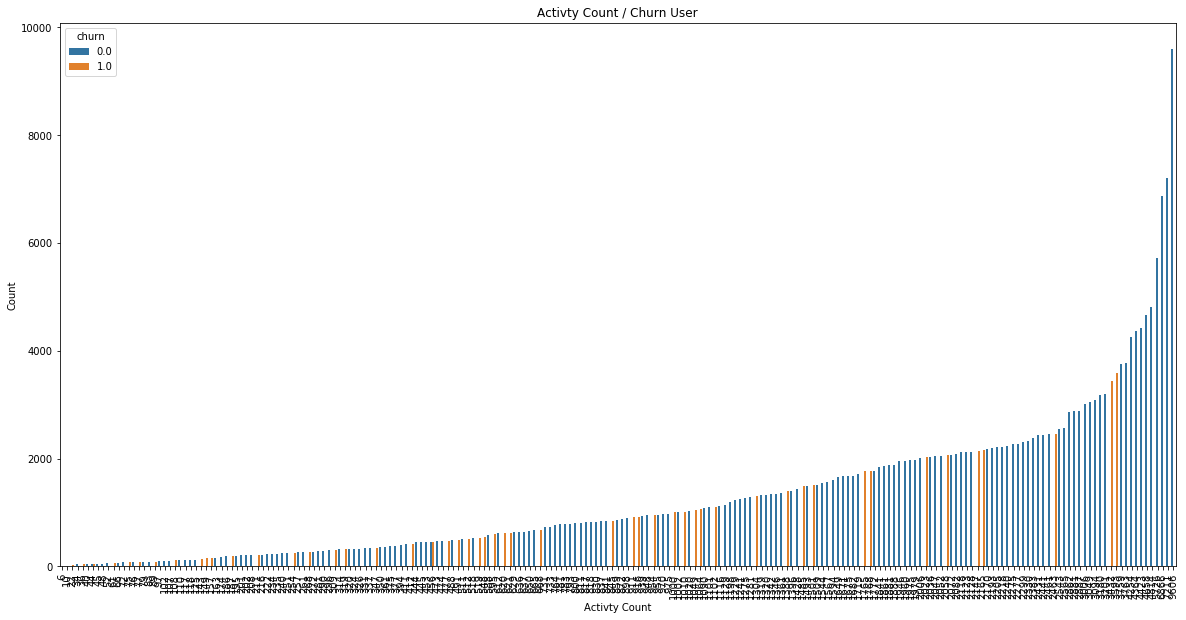

In [46]:
# Convert dataframe to pandas
activity_count = activity_count.toPandas().sort_values(by='activity', ascending=True)

# Plot Size
fig=plt.figure(figsize=(20,10))

#Initiate Plot
sns.barplot(x="activity", y="activity", hue="churn", data=activity_count);

# X-axis descriptions at 90degrees
plt.xticks(rotation=90);

# Axis Labelling
plt.title("Activty Count / Churn User")
plt.xlabel("Activty Count")
plt.ylabel("Count")

In [47]:
# Show count of artists and categorise if the user churns during the membership
artist_count = churn_data.groupBy("churn", "userId")\
    .agg(typ.countDistinct("artist")).sort("count(DISTINCT artist)", ascending=False)
artist_count.show()

+-----+------+----------------------+
|churn|userId|count(DISTINCT artist)|
+-----+------+----------------------+
|  0.0|    39|                  3544|
|  0.0|    92|                  2904|
|  0.0|   140|                  2819|
|  0.0|300011|                  2491|
|  0.0|   124|                  2232|
|  0.0|300021|                  2167|
|  0.0|    85|                  2124|
|  0.0|    42|                  2073|
|  0.0|300017|                  2070|
|  0.0|     6|                  1868|
|  1.0|    29|                  1804|
|  0.0|200023|                  1756|
|  1.0|    54|                  1744|
|  0.0|   100|                  1705|
|  0.0|     9|                  1672|
|  0.0|   126|                  1643|
|  0.0|    91|                  1618|
|  0.0|300015|                  1601|
|  0.0|    74|                  1557|
|  0.0|    98|                  1534|
+-----+------+----------------------+
only showing top 20 rows



In [48]:
# Average number of artists a churn user listens to
artist_count.filter(artist_count['churn'] == 1).agg(avg(col("count(DISTINCT artist)"))).show()

+---------------------------+
|avg(count(DISTINCT artist))|
+---------------------------+
|          518.6923076923077|
+---------------------------+



In [49]:
# Average number of artists a non-churn user listens to
artist_count.filter(artist_count['churn'] == 0).agg(avg(col("count(DISTINCT artist)"))).show()

+---------------------------+
|avg(count(DISTINCT artist))|
+---------------------------+
|          749.7861271676301|
+---------------------------+



There is a different in average number of artists a churn and non churn listens to however it could show more if we combine the artist and song together and see how this fits.

In [50]:
# Create new column with concatenating artist and song
unique_songs = churn_data.withColumn('uniqueSongsartist', 
                    typ.concat(typ.col('artist'),typ.lit(','), typ.col('song')))

In [51]:
# Count unique number of unique artist/songs a user listens to
unique_songs_df = unique_songs.groupBy('churn','userId').agg((typ.countDistinct(typ.col('uniqueSongsartist')))\
        .alias("songs")).orderBy('songs')\
        .sort("songs", ascending=True)
unique_songs_df.show(5)

+-----+------+-----+
|churn|userId|songs|
+-----+------+-----+
|  0.0|   156|    3|
|  0.0|   135|    6|
|  1.0|   125|    8|
|  1.0|100011|   11|
|  1.0|100024|   22|
+-----+------+-----+
only showing top 5 rows



In [52]:
# Average number of artists/songs a churn user listens to
unique_songs_df.filter(unique_songs_df['churn'] == 1).agg(avg(col("songs"))).show()

+-----------------+
|       avg(songs)|
+-----------------+
|642.1730769230769|
+-----------------+



In [53]:
# Average number of artists/songs a non-churn user listens to
unique_songs_df.filter(unique_songs_df['churn'] == 0).agg(avg(col("songs"))).show()

+-----------------+
|       avg(songs)|
+-----------------+
|984.1734104046243|
+-----------------+



This does show a significant difference, so this feature could be useful in modelling.

In [54]:
# Calculate the average length of track a user listens to
length_avg = churn_data.groupBy("churn", "userId")\
    .agg(typ.avg("length"))
length_avg.show()

+-----+------+------------------+
|churn|userId|       avg(length)|
+-----+------+------------------+
|  0.0|100010|  243.421444909091|
|  0.0|200002|242.91699209302323|
|  1.0|   125|       261.1391375|
|  0.0|   124|248.17653659965666|
|  1.0|    51| 247.8805508289908|
|  0.0|     7|253.56058066666665|
|  0.0|    15|249.37701452978044|
|  1.0|    54|250.38539934530132|
|  0.0|   155|242.41377060975574|
|  1.0|100014| 263.4376345525294|
|  0.0|   132|250.58034431535262|
|  0.0|   154|245.95266559523813|
|  1.0|   101| 249.0061294769059|
|  0.0|    11|246.78510516228766|
|  0.0|   138|247.56032983574823|
|  0.0|300017|247.08341966134319|
|  1.0|100021|250.57902452173914|
|  1.0|    29|249.18017257925987|
|  0.0|    69|254.27913390222233|
|  0.0|   112|246.80347251162794|
+-----+------+------------------+
only showing top 20 rows



In [55]:
# Average length of track a churn user listens to
length_avg.filter(length_avg['churn'] == 1).agg(avg(col("avg(length)"))).show()

+------------------+
|  avg(avg(length))|
+------------------+
|248.30786496247958|
+------------------+



In [56]:
# Average length of track a non-churn user listens to
length_avg.filter(length_avg['churn'] == 0).agg(avg(col("avg(length)"))).show()

+-----------------+
| avg(avg(length))|
+-----------------+
|249.1412535406481|
+-----------------+



The average length of a track shows no difference between users. The length of the track may be useful if we want to see whether or not a user skips during a track or not.

In [57]:
# Create column to count type of user agent against whether the user is a churn user or not
userAgent_count = churn_data.groupBy("churn", "userAgent")\
    .agg(typ.count("userAgent")).sort("count(userAgent)", ascending=False)
userAgent_count.show()

+-----+--------------------+----------------+
|churn|           userAgent|count(userAgent)|
+-----+--------------------+----------------+
|  0.0|"Mozilla/5.0 (Win...|           18226|
|  0.0|"Mozilla/5.0 (Mac...|           16298|
|  0.0|"Mozilla/5.0 (Mac...|           15914|
|  0.0|"Mozilla/5.0 (Win...|           15237|
|  0.0|Mozilla/5.0 (Wind...|           15224|
|  0.0|"Mozilla/5.0 (Mac...|           14875|
|  0.0|"Mozilla/5.0 (Win...|           12823|
|  0.0|"Mozilla/5.0 (iPa...|            8912|
|  0.0|Mozilla/5.0 (comp...|            8624|
|  0.0|Mozilla/5.0 (Maci...|            7838|
|  0.0|"Mozilla/5.0 (Mac...|            7638|
|  0.0|"Mozilla/5.0 (Win...|            6531|
|  0.0|"Mozilla/5.0 (Mac...|            6165|
|  0.0|"Mozilla/5.0 (Mac...|            5716|
|  0.0|"Mozilla/5.0 (Win...|            5553|
|  0.0|"Mozilla/5.0 (iPh...|            5407|
|  0.0|"Mozilla/5.0 (Win...|            5238|
|  0.0|Mozilla/5.0 (Wind...|            4925|
|  1.0|"Mozilla/5.0 (Mac...|      

Text(0,0.5,'Count of Occurance')

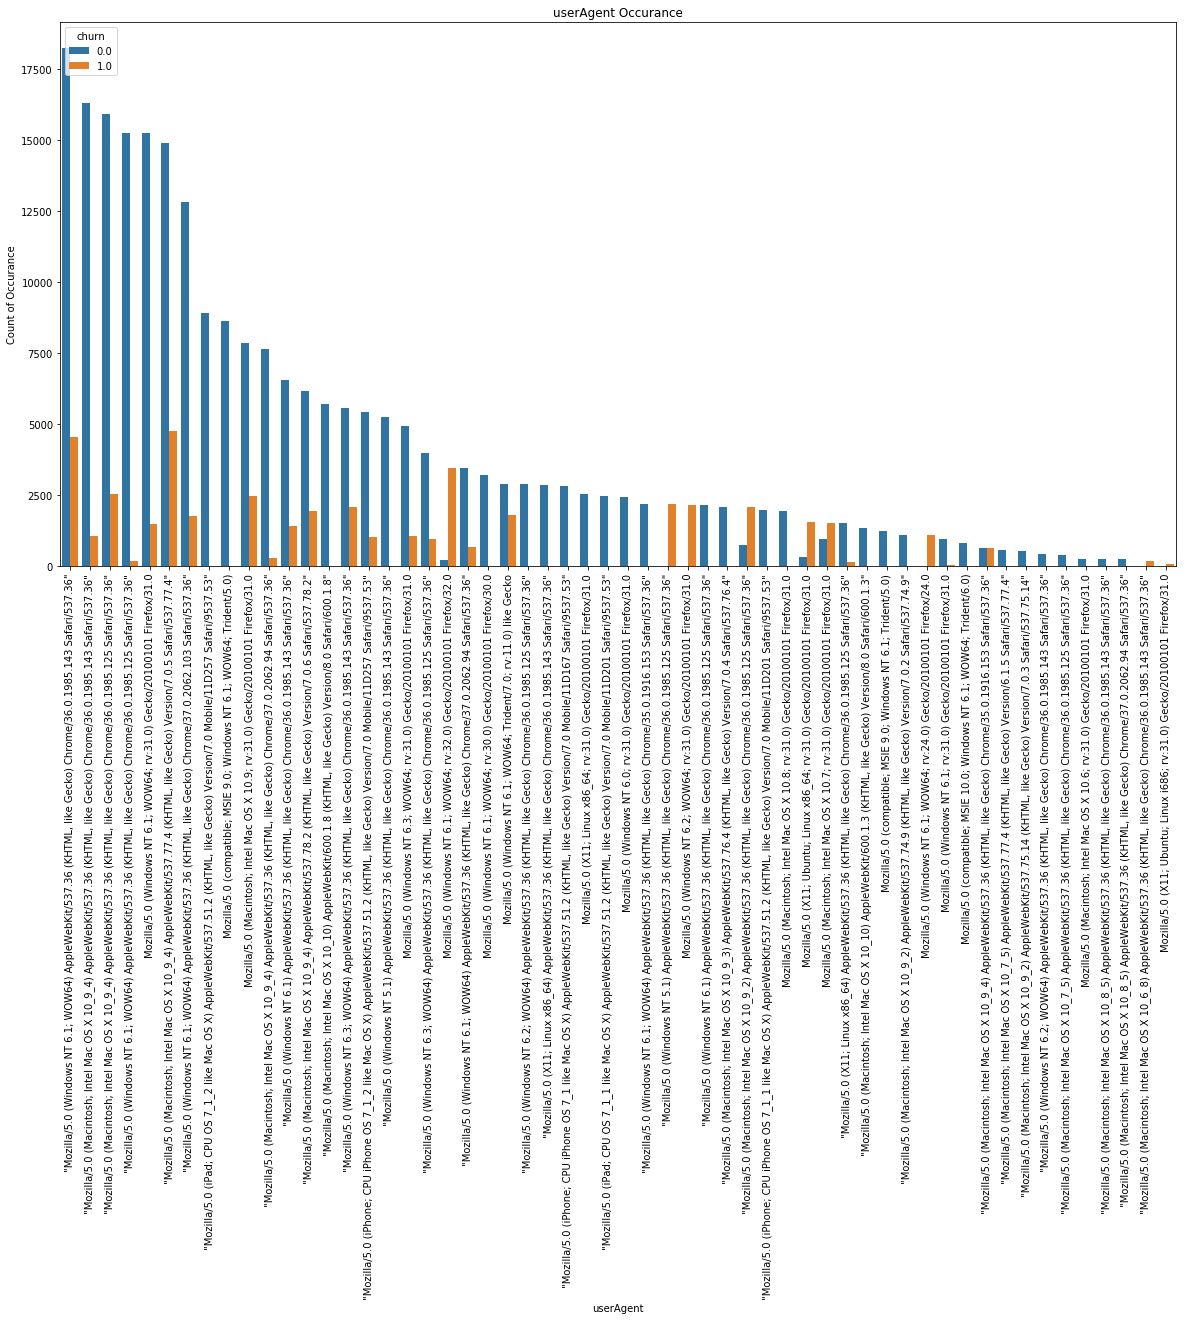

In [58]:
# Convert dataframe to pandas
userAgent_count = userAgent_count.toPandas()

# Plot Size
fig=plt.figure(figsize=(20,10))

#Initiate Plot
sns.barplot(x="userAgent", y="count(userAgent)", hue="churn", data=userAgent_count);

# X-axis descriptions at 90degrees
plt.xticks(rotation=90);

# Axis Labelling
plt.title("userAgent Occurance")
plt.xlabel("userAgent")
plt.ylabel("Count of Occurance")

This also shows that some useragents the there are more likely to get users which will churn. There are however some userAgents which have a 100% churn rate. This could possibly bias the model so i will initially leave this feature out.

### Summary
In summary, there were 7 features which appear most relevant or have visible connections to suggesting a user would cancel their subscription (including the churn feature as the label). These will be the features i will engineer to prepare for the modelling:

- User Churn
- Gender
- Subscription Type (Paid vs Free)
- Event - Roll Adverts
- Event - Thumbs Down
- Event - Thumbs Up
- Sum of number of unique songs / artists

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [59]:
def feature_engineering(df):

    '''
    Prepare dataset and engineer features for modelling
    Input - df - dataframe from sparkify
    Output - df - prepared dataframe for modelling

    '''
    
    # Clean initial dataset
    cleaned_df = df.filter(df["userId"] != "")
    cleaned_df = cleaned_df.dropDuplicates()

    # Define Churn iteration
    churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0)
    # Add churn user column as label
    churn_df = cleaned_df.withColumn("label", churn("page"))
    window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    churn_df = churn_df.withColumn("label", ssum("label").over(window))
    churn_df = churn_df.select("userId", "label","gender")
    churn_df = churn_df.dropDuplicates()
    churn_df = churn_df.filter(df["userId"] != "")

    # Find the subscription type from the level column
    subscription = cleaned_df.select(col("userId"), last("level")\
                   .over(Window.partitionBy(["userId"])).alias("level"),\
                   col("userId")).dropDuplicates()
    # Add to new dataframe
    churn_df = subscription.join(churn_df, "userId", "left")
    
    # Count the thumbs up activity per userId
    thumbs_up_count = cleaned_df.filter(cleaned_df.page == "Thumbs Up").groupby("userId").count()
    churn_df = churn_df.join(thumbs_up_count, "userId", "left")
    churn_df = churn_df.fillna(0, ["count"])
    churn_df = churn_df.withColumnRenamed("count", "ThumbsUpCount")

    # Count the thumbs down activity per userId
    thumbs_down_count = cleaned_df.filter(cleaned_df.page == "Thumbs Down").groupby("userId").count()
    churn_df = churn_df.join(thumbs_down_count, "userId", "left")
    churn_df = churn_df.fillna(0, ["count"])
    churn_df = churn_df.withColumnRenamed("count", "ThumbsDownCount")

    # Count the Adverts seen per userId
    roll_advert = cleaned_df.filter(cleaned_df.page == "Roll Advert").groupby("userId").count()
    churn_df = churn_df.join(roll_advert, "userId", "left")
    churn_df = churn_df.fillna(0, ["count"])
    churn_df = churn_df.withColumnRenamed("count", "RollAdvertCount")

    # Define the unique songs/artist column
    unique_songs = cleaned_df.withColumn('uniqueSongsArtist', 
                   typ.concat(typ.col('artist'),typ.lit(','), typ.col('song')))

    # Count the unique songs/artist per userId
    unique_songs_df = unique_songs.groupBy('userId').agg((typ.countDistinct(typ.col('uniqueSongsartist')))\
                      .alias("uniqueSongsArtist"))
    # Add to new dataframe
    df = churn_df.join(unique_songs_df, "userId", "left")

    # Define iteration to convert to numeric values   
    gender_to_numeric = udf(lambda x: 1 if x == "M" else 0)
    level_to_numeric = udf(lambda x: 1 if x == "free" else 0)
    
    # Run iteration and on gender and level columns      
    df = df.withColumn("gender", gender_to_numeric("gender"))
    df = df.withColumn("level", level_to_numeric("level"))
    
    
    # String indexer to convert string to numeric 
    indexer_gender = StringIndexer(inputCol="gender", outputCol="genderNumeric")
    df = indexer_gender.fit(df).transform(df)    
    indexer_level = StringIndexer(inputCol="level", outputCol="levelNumeric")
    df = indexer_level.fit(df).transform(df)
    
    return df

In [60]:
# Run function
modelling_df = feature_engineering(df)

In [61]:
# Show dataset
modelling_df.show(5)

+------+-----+-----+------+-------------+---------------+---------------+-----------------+-------------+------------+
|userId|level|label|gender|ThumbsUpCount|ThumbsDownCount|RollAdvertCount|uniqueSongsArtist|genderNumeric|levelNumeric|
+------+-----+-----+------+-------------+---------------+---------------+-----------------+-------------+------------+
|100010|    1|  0.0|     0|           17|              5|             52|              270|          1.0|         1.0|
|200002|    0|  0.0|     1|           21|              6|              7|              378|          0.0|         0.0|
|   125|    1|  1.0|     1|            0|              0|              1|                8|          0.0|         1.0|
|   124|    0|  0.0|     0|          171|             41|              4|             3392|          1.0|         0.0|
|    51|    0|  1.0|     1|          100|             21|              0|             1868|          0.0|         0.0|
+------+-----+-----+------+-------------+-------

In [62]:
# Count number of rows to validate users
modelling_df.count()

225

In [63]:
# Review dataframe structure
modelling_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- level: string (nullable = true)
 |-- label: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- ThumbsUpCount: long (nullable = true)
 |-- ThumbsDownCount: long (nullable = true)
 |-- RollAdvertCount: long (nullable = true)
 |-- uniqueSongsArtist: long (nullable = true)
 |-- genderNumeric: double (nullable = false)
 |-- levelNumeric: double (nullable = false)



In [64]:
# Define vector transformation features
vector_assemble = VectorAssembler(inputCols=["levelNumeric", "genderNumeric", "ThumbsUpCount" \
                  , "ThumbsDownCount", "RollAdvertCount", "uniqueSongsArtist"], outputCol="features")

In [65]:
# Scaling the vectors
scaler = StandardScaler(inputCol="features", outputCol="scaledfeatures")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [66]:
# Split the dataset into train and test sets
training, test = modelling_df.randomSplit([0.7, 0.3]);
training.count(), test.count()

(146, 79)

In [67]:
# Building Pipeline - Logistic Regression
lr = LogisticRegression(featuresCol="scaledfeatures", labelCol="label", maxIter=10, regParam=0.01)
pipeline_lr = Pipeline(stages=[vector_assemble, scaler, lr])

In [68]:
# Fit model
model_lr = pipeline_lr.fit(training)

In [69]:
# Function to print results as accuracy and f1 score

def print_results(model, test):
    
    '''
    Function to print accuracy and f1 score results for each model

    Input: model = model used. test = test data set
    Output: print statement of accuracy and f1 score

    '''

    accuracy = MulticlassClassificationEvaluator(metricName = 'accuracy')
    prediction = model.transform(test)
    accuracy = (accuracy.evaluate(prediction)*100)

    f1 = MulticlassClassificationEvaluator(metricName = 'f1')
    prediction = model.transform(test)
    f1 = (f1.evaluate(prediction)*100)
    print("Accuracy = ",accuracy,"%", "F1 = ",f1,"%")

    #return accuracy,f1

In [70]:
print_results(model_lr,test)

Accuracy =  72.15189873417721 % F1 =  62.602382725242 %


In [71]:
# Tune parameters - Logistic Regression
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [72]:
# Fit tuned model
lr_tuned = crossval.fit(training)

In [73]:
print_results(lr_tuned,test)

Accuracy =  72.15189873417721 % F1 =  64.53177152213615 %


In [80]:
# Building Pipeline - Random Forest
rf = RandomForestClassifier(featuresCol="scaledfeatures", labelCol="label")
pipeline_rf = Pipeline(stages=[vector_assemble, scaler, rf])

In [75]:
# Fit model
model_rf = pipeline_rf.fit(training)

In [76]:
# Print Results
print_results(model_rf,test)

Accuracy =  73.41772151898735 % F1 =  65.26753500886686 %


In [83]:
# Tune parameters - Random Forest

paramGrid=ParamGridBuilder().addGrid(rf.maxDepth, [5, 10, 15]).build()
crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [84]:
# Fit tuned model
rf_tuned = crossval.fit(training)

In [85]:
# Print Results
print_results(rf_tuned,test)

Accuracy =  75.9493670886076 % F1 =  70.09041591320072 %


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.